<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/all_town_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 町の全スコア
- input:
    - population_master.csv
        - 町丁ごとの位置
    - train_station.csv
        - 最寄り駅
    - childcare_score.csv
        - 子育てスコア
            - 保育園スコア
            - 幼稚園スコア
    - education_score.csv
        - 教育スコア
            - 小学校スコア
            - 中学校スコア
            - 図書館スコア
    - convenience_score.csv
        - 利便性スコア
    - environment_score.csv
        - 周辺環境スコア
            - 公園スコア
            - 運動場スコア
            - 体育館スコア
            - プールスコア
    - medical_score.csv
        - 医療スコア
    - crime_score.csv
        - 治安スコア
- output:
    - all_town_score.csv
        - 町丁ごとの全スコアデータ

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
output_file = 'all_town_score.csv'

### 人口マスタ

In [6]:
df_population = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[
    ['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']
].set_index('地域ID')
print(df_population.shape)
df_population.head()

(3145, 5)


,市区町村名,町名,町丁目,緯度,経度
地域ID,,,,,
101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511
101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944
101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039
101007,千代田区,大手町,大手町１丁目,35.688067,139.764353
101008,千代田区,大手町,大手町２丁目,35.686416,139.768530


### 最寄り駅

In [7]:
df_train_station = pd.read_csv(os.path.join(DIR_NAME, 'train_station.csv'))[
    ['no', 'name']
].rename(columns={'name':'最寄り駅'}).set_index('no')
print(df_train_station.shape)
df_train_station.head()

(3141, 1)


,最寄り駅
no,
101003,東京駅
101004,東京駅
101005,有楽町駅
101007,大手町駅
101008,大手町駅


### 子育てスコア

In [8]:
df_childcare = pd.read_csv(os.path.join(DIR_NAME, 'childcare_score.csv'))[
    ['地域ID', '_幼稚園スコア', '_保育園スコア', '_子育てスコア', '子育てスコア']
].set_index('地域ID')
print(df_childcare.shape)
df_childcare.head()

(3145, 4)


,_幼稚園スコア,_保育園スコア,_子育てスコア,子育てスコア
地域ID,,,,
101003,0.738384,0.328537,0.522015,0.584242
101004,0.710050,0.241613,0.457213,0.378182
101005,0.858917,0.338905,0.595613,0.935758
101007,0.841715,0.489361,0.670533,1.533636
101008,0.882736,0.533646,0.718496,2.149697


### 教育スコア

In [9]:
df_education = pd.read_csv(os.path.join(DIR_NAME, 'education_score.csv'))[
    ['地域ID', '_小学校スコア', '_中学校スコア', '_図書館スコア', '_教育スコア', '教育スコア']
].set_index('地域ID')
print(df_education.shape)
df_education.head()

(3145, 5)


,_小学校スコア,_中学校スコア,_図書館スコア,_教育スコア,教育スコア
地域ID,,,,,
101003,0.758635,0.201413,0.446415,0.486956,0.267017
101004,0.665746,0.201413,0.449642,0.452262,0.221055
101005,0.648765,0.350953,0.504223,0.524674,0.356752
101007,0.660258,0.486260,0.622203,0.627129,1.257879
101008,0.811935,0.313534,0.611363,0.614790,1.110144


### 利便性スコア

In [10]:
df_convenience = pd.read_csv(os.path.join(DIR_NAME, 'convenience_score.csv'))[
    ['地域ID', '_利便性スコア', '利便性スコア']
].set_index('地域ID')
print(df_convenience.shape)
df_convenience.head()

(3145, 2)


,_利便性スコア,利便性スコア
地域ID,,
101003,0.888818,4.900244
101004,0.813370,4.745304
101005,0.812968,4.743182
101007,0.805295,4.726202
101008,0.845896,4.815345


### 周辺環境スコア

In [11]:
df_environment = pd.read_csv(os.path.join(DIR_NAME, 'environment_score.csv'))[
    ['地域ID', '_公園スコア', '_運動場スコア', '_体育館スコア', '_プールスコア', '_周辺環境スコア', '周辺環境スコア']
].set_index('地域ID')
print(df_environment.shape)
df_environment.iloc[300:305]

(3145, 6)


,_公園スコア,_運動場スコア,_体育館スコア,_プールスコア,_周辺環境スコア,周辺環境スコア
地域ID,,,,,,
103109,0.621296,0.437566,0.330523,0.834635,0.672536,2.719907
103110,0.560473,0.407723,0.361717,0.850393,0.635429,2.486772
103112,0.497027,0.445092,0.139281,0.647468,0.515596,1.938988
103113,0.564397,0.496658,0.176003,0.640616,0.576764,2.194114
103114,0.583418,0.460817,0.247047,0.638655,0.596083,2.293320


### 医療スコア

In [12]:
df_medical = pd.read_csv(os.path.join(DIR_NAME, 'medical_score.csv'))[
    ['地域ID', '_医療スコア', '医療スコア']
].set_index('地域ID')
print(df_medical.shape)
df_medical.head()

(3145, 2)


,_医療スコア,医療スコア
地域ID,,
101003,0.864693,4.662528
101004,0.748422,3.640481
101005,0.860611,4.643426
101007,0.844514,4.558527
101008,0.790270,4.127666


### 治安

In [13]:
df_crime = pd.read_csv(os.path.join(DIR_NAME, 'crime_score.csv'))[
    ['地域ID', '_犯罪スコア', '犯罪スコア']
].set_index('地域ID')
print(df_crime.shape)
df_crime.head()

(2921, 2)


,_犯罪スコア,犯罪スコア
地域ID,,
101003,0.454545,0.073034
101004,0.858494,1.027131
101005,0.801949,0.593404
101007,0.657322,0.189433
101008,0.804953,0.613945


### 全て結合

In [14]:
df_all_town_score = pd.concat([
    df_population,
    df_train_station,
    df_childcare,
    df_education,
    df_convenience,
    df_environment,
    df_medical,
    df_crime,
], axis=1)
df_all_town_score.index.name = '地域ID'
print(df_all_town_score.shape)

(3145, 27)


### データがないところは、同じ区の平均値で埋める

In [15]:
score_cols = [col for col in df_all_town_score.columns if col.endswith('スコア')]
print(len(score_cols))

21


In [16]:
for col in score_cols:
    df_all_town_score.loc[df_all_town_score[col].isna(), col] = df_all_town_score.groupby('市区町村名')[col].transform('mean')

In [17]:
df_all_town_score.head()

,市区町村名,町名,町丁目,緯度,経度,最寄り駅,_幼稚園スコア,_保育園スコア,_子育てスコア,子育てスコア,_小学校スコア,_中学校スコア,_図書館スコア,_教育スコア,教育スコア,_利便性スコア,利便性スコア,_公園スコア,_運動場スコア,_体育館スコア,_プールスコア,_周辺環境スコア,周辺環境スコア,_医療スコア,医療スコア,_犯罪スコア,犯罪スコア
地域ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,東京駅,0.738384,0.328537,0.522015,0.584242,0.758635,0.201413,0.446415,0.486956,0.267017,0.888818,4.900244,NaN,NaN,NaN,NaN,NaN,NaN,0.864693,4.662528,0.454545,0.073034
101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,東京駅,0.710050,0.241613,0.457213,0.378182,0.665746,0.201413,0.449642,0.452262,0.221055,0.813370,4.745304,NaN,NaN,NaN,NaN,NaN,NaN,0.748422,3.640481,0.858494,1.027131
101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,有楽町駅,0.858917,0.338905,0.595613,0.935758,0.648765,0.350953,0.504223,0.524674,0.356752,0.812968,4.743182,NaN,NaN,NaN,NaN,NaN,NaN,0.860611,4.643426,0.801949,0.593404
101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,大手町駅,0.841715,0.489361,0.670533,1.533636,0.660258,0.486260,0.622203,0.627129,1.257879,0.805295,4.726202,NaN,NaN,NaN,NaN,NaN,NaN,0.844514,4.558527,0.657322,0.189433
101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,大手町駅,0.882736,0.533646,0.718496,2.149697,0.811935,0.313534,0.611363,0.614790,1.110144,0.845896,4.815345,NaN,NaN,NaN,NaN,NaN,NaN,0.790270,4.127666,0.804953,0.613945


### 出力

In [18]:
df_all_town_score.to_csv(os.path.join(DIR_NAME, output_file), index=True)

### 重みづけを変えて、ランキングを表示
- 保育園(0~9)
- 子育て(0~9)
- 小学校(0~9)
- 中学校(0~9)
- 図書館
- 利便性
- 公園(0~9)
- 体育館(0~9)
- プール(0~9)
- 運動場(0~9)
- 病院(0~9)
- 治安(0~9)

In [19]:
weight_list = {
    '保育園': 1,
    '子育て': 1,
    '小学校': 1,
    '中学校': 2,
    '図書館': 7,
    '利便性': 9,
    '公園': 9,
    '体育館': 7,
    'プール': 8,
    '運動場': 9,
    '医療': 2,
    '犯罪': 5,
}

In [20]:
df_town_score = df_all_town_score.reset_index()

sum_weight = sum(weight_list.values())
weight_cols = []
for key, weight in weight_list.items():
    weight_col = f'weight_{key}'
    df_town_score[weight_col] = df_town_score[f'_{key}スコア'] * weight/sum_weight
    weight_cols.append(weight_col)

df_town_score['matching_score'] = df_town_score[weight_cols].sum(axis=1) * 100

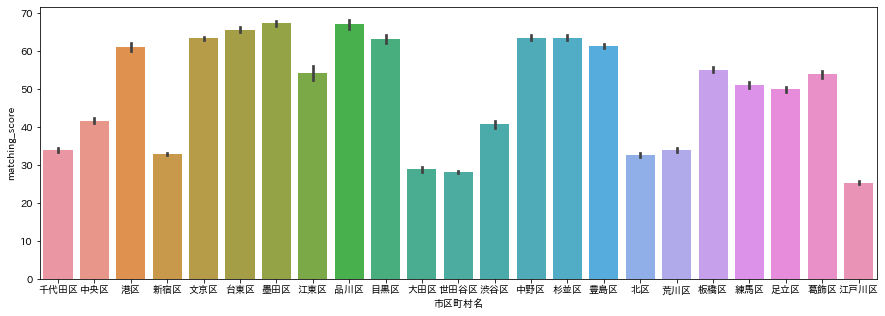

In [21]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y='matching_score', data=df_town_score)
plt.show()

In [22]:
df_town_score['rank'] = df_town_score.groupby('町名')['matching_score'].transform('rank', ascending=False)
df_ranking = df_town_score[df_town_score['rank'] == 1].sort_values('matching_score', ascending=False)[
    ['地域ID', '市区町村名', '町名', '町丁目', '最寄り駅', '子育てスコア', '教育スコア', '利便性スコア', '周辺環境スコア', '医療スコア', '犯罪スコア', 'matching_score']
].reset_index(drop=True)
print(df_ranking.shape)

(913, 12)


In [23]:
df_ranking.head(10)

,地域ID,市区町村名,町名,町丁目,最寄り駅,子育てスコア,教育スコア,利便性スコア,周辺環境スコア,医療スコア,犯罪スコア,matching_score
0,109140,品川区,豊町,豊町１丁目,下神明,3.342727,4.656380,3.113578,5.000000,2.925024,4.419149,77.213288
1,109136,品川区,戸越,戸越４丁目,戸越公園駅,3.433636,4.384986,3.836278,4.973545,4.261382,4.695310,76.146975
2,109126,品川区,西中延,西中延１丁目,荏原中延駅,4.367273,4.413438,4.129789,4.960317,4.834448,4.271939,75.608038
3,109130,品川区,東中延,東中延１丁目,荏原中延駅,3.828182,3.233257,3.869707,4.990079,4.603099,4.271939,75.465955
4,109110,品川区,平塚,平塚３丁目,戸越銀座駅,3.570000,4.647625,3.685053,4.980159,4.728324,4.551523,74.880135
5,109025,品川区,西品川,西品川３丁目,JR大崎駅,3.595455,4.459400,3.218641,4.844577,2.879391,3.441373,74.803963
6,109046,品川区,西五反田,西五反田６丁目,不動前駅,4.973333,4.899322,3.540194,4.904101,3.150191,3.032266,74.632680
7,109051,品川区,大崎,大崎２丁目,JR大崎駅,2.976364,4.608229,3.522684,4.854497,3.662767,2.202157,74.602206
8,109119,品川区,中延,中延１丁目,荏原中延駅,3.770000,4.317137,3.837870,4.947090,4.651916,4.551523,74.544615
9,109100,品川区,荏原,荏原１丁目,戸越銀座駅,4.713939,4.789888,3.412846,4.963624,3.702563,2.199304,74.534296


In [24]:
df_ranking['rank'] = df_ranking.groupby('最寄り駅')['matching_score'].transform('rank', ascending=False)
df_ranking_2 = df_ranking[df_ranking['rank'] == 1].sort_values('matching_score', ascending=False).drop(columns=['rank']).reset_index(drop=True)
print(df_ranking_2.shape)

(265, 12)


In [29]:
df_ranking_2.head(50)

,地域ID,市区町村名,町名,町丁目,最寄り駅,子育てスコア,教育スコア,利便性スコア,周辺環境スコア,医療スコア,犯罪スコア,matching_score
0,109140,品川区,豊町,豊町１丁目,下神明,3.342727,4.656380,3.113578,5.000000,2.925024,4.419149,77.213288
1,109136,品川区,戸越,戸越４丁目,戸越公園駅,3.433636,4.384986,3.836278,4.973545,4.261382,4.695310,76.146975
2,109126,品川区,西中延,西中延１丁目,荏原中延駅,4.367273,4.413438,4.129789,4.960317,4.834448,4.271939,75.608038
3,109110,品川区,平塚,平塚３丁目,戸越銀座駅,3.570000,4.647625,3.685053,4.980159,4.728324,4.551523,74.880135
4,109025,品川区,西品川,西品川３丁目,JR大崎駅,3.595455,4.459400,3.218641,4.844577,2.879391,3.441373,74.803963
5,109046,品川区,西五反田,西五反田６丁目,不動前駅,4.973333,4.899322,3.540194,4.904101,3.150191,3.032266,74.632680
6,110036,目黒区,目黒,目黒２丁目,目黒駅,2.972727,4.601663,2.598164,4.232804,3.388968,2.381890,74.063089
7,107090,墨田区,東向島,東向島４丁目,東向島駅,2.887879,3.441727,4.119176,4.983466,3.936565,1.298442,73.084715
8,107108,墨田区,京島,京島２丁目,京成曳舟駅,2.879394,2.583169,3.341213,4.900794,3.110395,3.533807,72.862829
9,107119,墨田区,八広,八広５丁目,八広駅,4.602424,4.715474,3.242518,4.785053,2.259631,3.546645,72.300617


In [28]:
df_ranking_2.tail(10)

,地域ID,市区町村名,町名,町丁目,最寄り駅,子育てスコア,教育スコア,利便性スコア,周辺環境スコア,医療スコア,犯罪スコア,matching_score
255,123151,江戸川区,篠崎町,篠崎町７丁目,市川駅,0.448485,3.280860,0.375677,NaN,2.115303,1.266775,27.386518
256,102116,中央区,豊海町,豊海町,竹芝駅,2.596970,0.284526,1.166905,0.049603,0.636740,2.780380,27.296252
257,112163,世田谷区,上野毛,上野毛１丁目,上野毛駅,3.450000,0.825126,2.454898,NaN,2.674573,1.408850,27.140051
258,123073,江戸川区,東瑞江,東瑞江１丁目,市川塩浜駅,0.913939,2.842526,0.441473,NaN,2.653348,1.728946,25.747380
259,123163,江戸川区,南篠崎町,南篠崎町３丁目,本八幡駅,1.095455,1.259521,0.379921,NaN,2.779635,3.477319,25.036016
260,111044,大田区,昭和島,昭和島１丁目,昭和島駅,0.630303,0.326111,0.848987,NaN,0.195267,4.391761,24.301303
261,112168,世田谷区,野毛,野毛１丁目,等々力駅,1.315455,0.398337,0.732251,NaN,0.248329,4.075659,23.440485
262,112263,世田谷区,宇奈根,宇奈根１丁目,久地駅,0.838788,0.551543,0.320492,NaN,0.218614,3.746063,22.480134
263,123229,江戸川区,堀江町,堀江町,東京ディズニーランド・ステーション駅,0.315152,0.470562,0.921150,NaN,1.098456,2.418277,22.452159
264,111095,大田区,東海,東海１丁目,流通センター駅,0.247273,0.072226,0.787435,NaN,0.038204,2.523964,17.735557


In [27]:
top_id = df_ranking_2.iloc[0]['地域ID']
df_all_town_score.loc[top_id]

市区町村名              品川区
町名                  豊町
町丁目              豊町１丁目
緯度           35.613229
経度          139.722771
最寄り駅               下神明
_幼稚園スコア       0.683639
_保育園スコア       0.896677
_子育てスコア       0.810666
子育てスコア        3.342727
_小学校スコア       0.751497
_中学校スコア       0.747259
_図書館スコア       0.897037
_教育スコア        0.869771
教育スコア          4.65638
_利便性スコア        0.58536
利便性スコア        3.113578
_公園スコア        0.961622
_運動場スコア       0.540078
_体育館スコア       0.800265
_プールスコア       0.766144
_周辺環境スコア           1.0
周辺環境スコア            5.0
_医療スコア        0.699679
医療スコア         2.925024
_犯罪スコア        0.990716
犯罪スコア         4.419149
Name: 109140, dtype: object